<a href="https://colab.research.google.com/github/saritmaitra/DJIA_Prophet_LSTM/blob/main/DJIA_Prophet_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
plt.style.use('ggplot')


In [2]:
dji = web.DataReader('^DJI', data_source = 'yahoo', start = '2000-01-01')
print(dji.head())
print('\n')
print(dji.shape)

                    High           Low          Open         Close   Volume     Adj Close
Date                                                                                     
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  1697500  11357.509766
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  1784200  10997.929688
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  2031900  11122.650391
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  1765500  11253.259766
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  1849000  11522.559570


(5289, 6)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

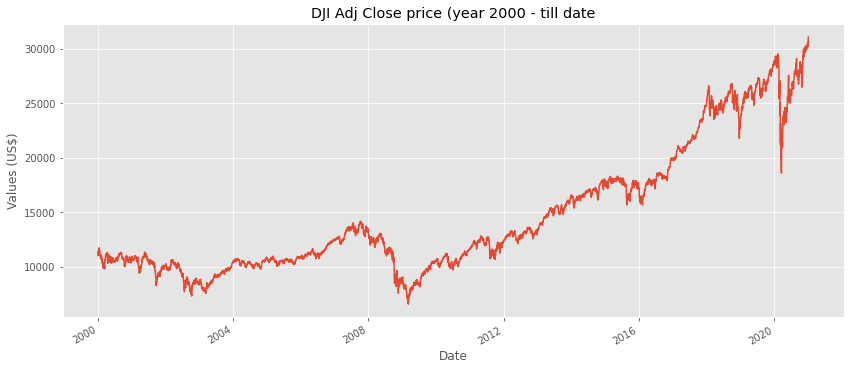

In [3]:
plt.rcParams['figure.figsize'] = [14,6]
dji_series = dji['Adj Close']
dji_series.plot()
plt.ylabel('Values (US$)')
plt.title('DJI Adj Close price (year 2000 - till date')
plt.show()

In [4]:
#Calculate the simple and log returns using the adjusted close prices:
dji['simple_rtn'] = dji_series.pct_change()
dji['log_rtn'] = np.log(dji_series/dji_series.shift(1))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

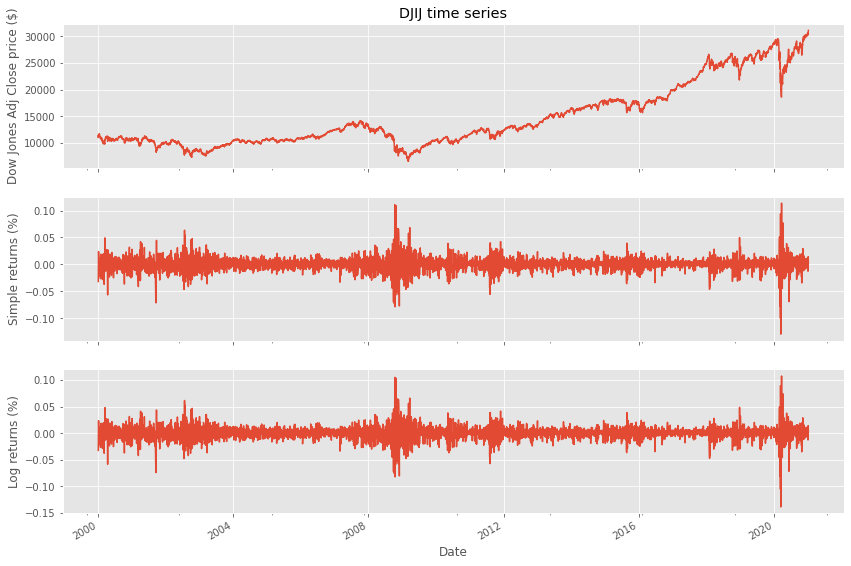

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
dji_series.plot(ax=ax[0])
ax[0].set(title = 'DJIJ time series', ylabel = 'Dow Jones Adj Close price ($)')
dji.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
dji.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', ylabel = 'Log returns (%)')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

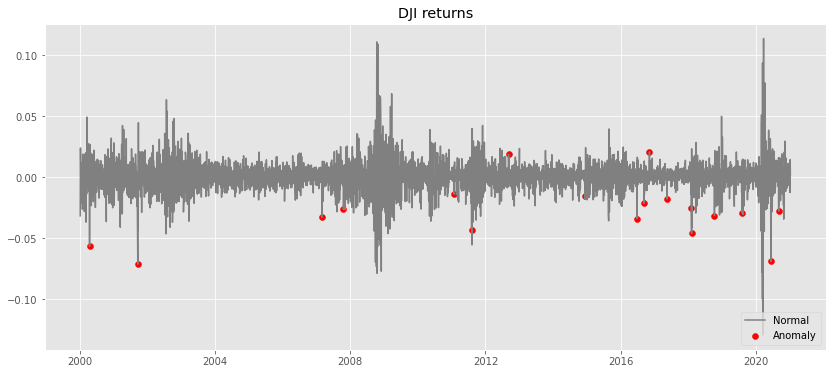

In [6]:
#Calculate the rolling mean and standard deviation:
df_rolling = dji[['simple_rtn']].rolling(window=21) .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

#Join the rolling metrics to the original data:
df_outliers = dji.join(df_rolling)

#Define a function for detecting outliers:
def indentify_outliers(row, n_sigmas=3):
  x = row['simple_rtn']
  mu = row['mean']
  sigma = row['std']
  if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
    return 1
  else:
    return 0

#Identify the outliers and extract their values for later use:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1,['simple_rtn']]

#Plot the results:
fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.simple_rtn, color='gray', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
ax.set_title("DJI returns")
ax.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

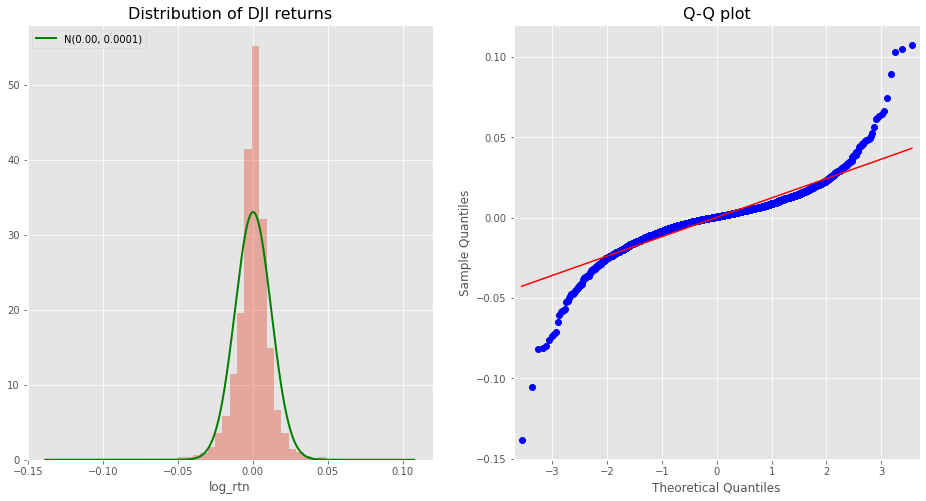

In [7]:
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

r_range = np.linspace(min(dji['log_rtn'].dropna()), max(dji['log_rtn'].dropna()), num=1000)
mu = dji['log_rtn'].dropna().mean()
sigma = dji['log_rtn'].dropna().std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

#Plot the histogram and the Q-Q plot:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# histogram
sns.distplot(dji['log_rtn'].dropna(), kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of DJI returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');
# Q-Q plot
qq = sm.qqplot(dji['log_rtn'].dropna().values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
plt.show()

In [8]:
dji['log_rtn'].describe()

count    5288.000000
mean        0.000190
std         0.012076
min        -0.138418
25%        -0.004610
50%         0.000514
75%         0.005591
max         0.107643
Name: log_rtn, dtype: float64

In [9]:
import scipy

print("kurtosis:", scipy.stats.kurtosis(dji['log_rtn'].dropna(),bias=False))
print("skewness:", scipy.stats.skew(dji['log_rtn'].dropna(),bias=False))
print("JB:", scipy.stats.jarque_bera(dji['log_rtn'].dropna()))

kurtosis: 13.03202267417283
skewness: -0.3775068706795118
JB: (37468.3151554281, 0.0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

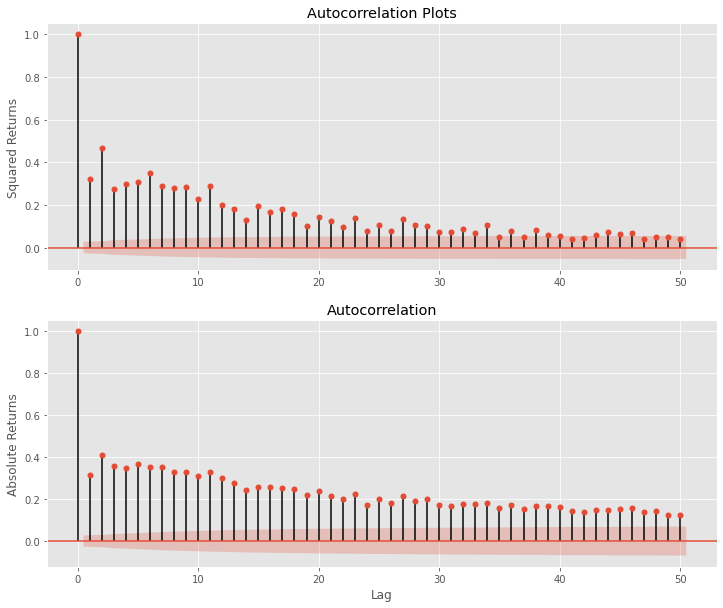

In [10]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
smt.graphics.plot_acf(dji['log_rtn'].dropna() ** 2, lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots', ylabel='Squared Returns')
smt.graphics.plot_acf(np.abs(dji['log_rtn'].dropna()), lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',xlabel='Lag')
plt.show()

In [11]:
import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

import keras
from sklearn.metrics import mean_squared_error
import pandas_datareader as pdr

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler

In [12]:
# prepare training and testing data sets for LSTM based regression modeling
def get_reg_train_test(timeseries,sequence_length= 51,
                   train_size=0.9,roll_mean_window=5,
                   normalize=True,scale=False):
    # smoothen out series
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
    
    # create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        result.append(timeseries[index: index + sequence_length])
           
    
    # normalize data as a variation of 0th index
    if normalize:
        normalised_data = []
        for window in result:
            normalised_window = [((float(p) / float(window[0])) - 1) \
                                   for p in window]
            normalised_data.append(normalised_window)
        result = normalised_data
    
    # identify train-test splits
    result = np.array(result) 
    row = round(train_size * result.shape[0])
    
    # split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # scale data in 0-1 range
    scaler = None
    if scale:
        scaler=MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
      
    # split independent and dependent variables  
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # Transforms for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], 
                                   x_train.shape[1], 
                                   1))
    x_test = np.reshape(x_test, (x_test.shape[0], 
                                 x_test.shape[1], 
                                 1)) 
    
    return x_train,y_train,x_test,y_test,scaler   

In [13]:
# training and testing data sets for LSTM based sequence modeling
def get_seq_train_test(time_series, scaling=True,train_size=0.9):
    scaler = None
    if scaling:
        scaler = MinMaxScaler(feature_range=(0, 1))
        time_series = np.array(time_series).reshape(-1,1)
        scaled_stock_series = scaler.fit_transform(time_series)
    else:
        scaled_stock_series = time_series
        
    train_size = int(len(scaled_stock_series) * train_size)

    train = scaled_stock_series[0:train_size]
    test = scaled_stock_series[train_size:len(scaled_stock_series)]
    
    return train,test,scaler 

In [14]:
# stacked LSTM model for regression modeling
def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):
    # build LSTM network
    model = Sequential()
    
    # hidden layer 1
    model.add(LSTM(layer_units[0], 
                   input_shape=(window_size,1), 
                   return_sequences=True))
    model.add(Dropout(dropouts[0]))
    
    # hidden layer 2
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))
    
    # output layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model

In [15]:
# LSTM model for sequence modeling
def get_seq_model(hidden_units=4,input_shape=(1,1),verbose=False):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*featuress

    model.add(LSTM(input_shape=input_shape, 
                   units = hidden_units, 
                   return_sequences=True))
    
    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    model.add(TimeDistributed(Dense(1)))
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    if verbose:
        print("> Compilation Time : ", time.time() - start)
        print(model.summary())
        
    return model

In [16]:
# Window wise prediction function
def predict_reg_multiple(model, data, window_size=6, prediction_len=3):
    prediction_list = []
    
    # loop for every sequence in the dataset
    for window in range(int(len(data)/prediction_len)):
        _seq = data[window*prediction_len]
        predicted = []
        # loop till required prediction length is achieved
        for j in range(prediction_len):
            predicted.append(model.predict(_seq[np.newaxis,:,:])[0,0])
            _seq = _seq[1:]
            _seq = np.insert(_seq, [window_size-1], predicted[-1], axis=0)
        prediction_list.append(predicted)
    return prediction_list

In [17]:
# Plot 
def plot_reg_results(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    
    # plot actual data
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    
    # plot flattened data
    plt.plot(np.array(predicted_data).flatten(), 
             label='Prediction_full',
             c='g',linestyle='--')
    
    #plot each window in the prediction list
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction Window={}".format(prediction_len))
    plt.show()

In [ ]:
#dataset.tail(1)

In [19]:
from fbprophet import Prophet

# reset index to get date_time as a column
prophet = dji_series.reset_index()

# prepare the required dataframe
prophet.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)
prophet = prophet[['ds','y']]

In [20]:
train_percent = 0.90
# prepare train and test sets
train_size = int(prophet.shape[0]*train_percent)
train = prophet.iloc[:train_size]
test = prophet.iloc[train_size+1:]

In [21]:
test.tail()

,ds,y
5284,2021-01-04,30223.890625
5285,2021-01-05,30391.599609
5286,2021-01-06,30829.400391
5287,2021-01-07,31041.130859
5288,2021-01-08,31097.970703


In [22]:
# build a prophet model
model_prophet = Prophet()

# fit the model
model_prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
test.shape[0]

528

In [24]:
# prepare a future dataframe
future_dates = model_prophet.make_future_dataframe(periods=test.shape[0])
# test.shape[0] = 515

# forecast values
forecast = model_prophet.predict(future_dates)

**Plot test prediction**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

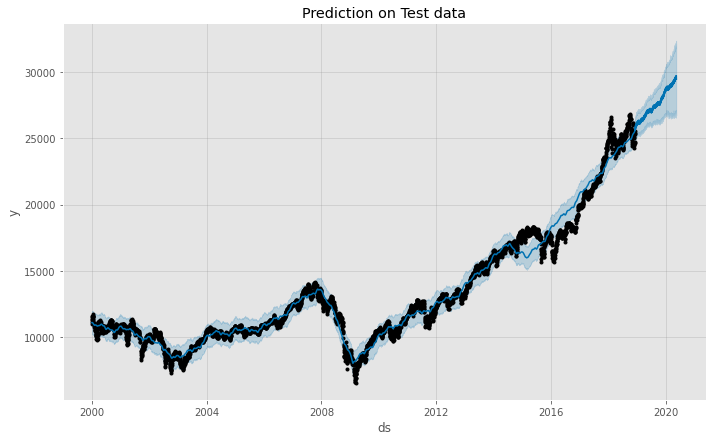

In [25]:
plt.rcParams['figure.figsize'] = [14,6]
model_prophet.plot(forecast)
plt.title('Prediction on Test data')
plt.show()

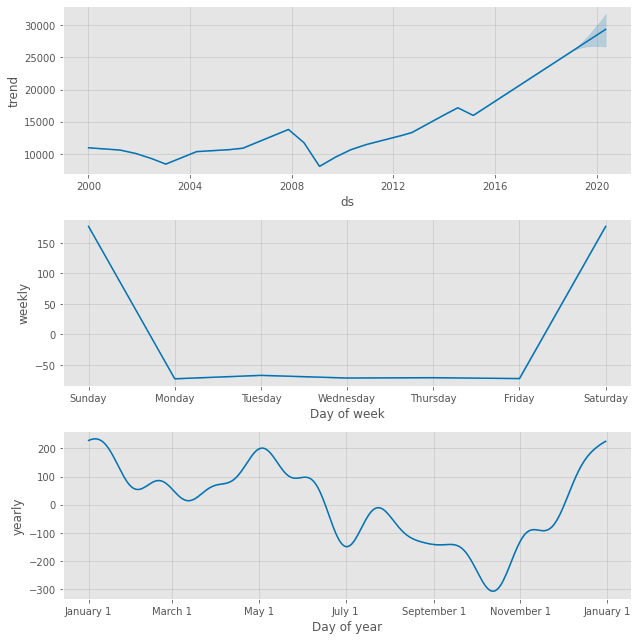

In [26]:
fig1 = model_prophet.plot_components(forecast)

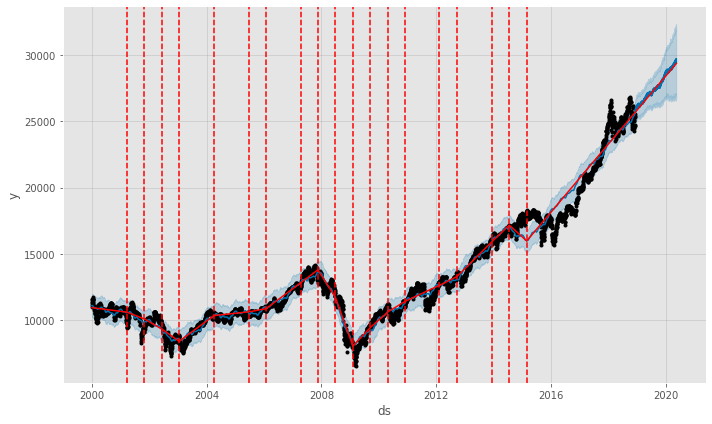

In [27]:
from fbprophet.plot import add_changepoints_to_plot
fig = model_prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_prophet, forecast)

In [28]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-03,10929.050311,10224.382985,11937.643271,10929.050311,10929.050311,158.269799,158.269799,158.269799,-72.691701,-72.691701,-72.691701,230.961500,230.961500,230.961500,0.0,0.0,0.0,11087.320110
1,2000-01-04,10928.301621,10261.116090,11912.052740,10928.301621,10928.301621,165.465720,165.465720,165.465720,-67.058620,-67.058620,-67.058620,232.524340,232.524340,232.524340,0.0,0.0,0.0,11093.767341
2,2000-01-05,10927.552931,10264.482737,11931.208240,10927.552931,10927.552931,162.201743,162.201743,162.201743,-71.407442,-71.407442,-71.407442,233.609185,233.609185,233.609185,0.0,0.0,0.0,11089.754674
3,2000-01-06,10926.804242,10215.697353,11955.456431,10926.804242,10926.804242,163.268262,163.268262,163.268262,-70.882075,-70.882075,-70.882075,234.150336,234.150336,234.150336,0.0,0.0,0.0,11090.072503
4,2000-01-07,10926.055552,10228.531427,11929.007814,10926.055552,10926.055552,161.783920,161.783920,161.783920,-72.298502,-72.298502,-72.298502,234.082422,234.082422,234.082422,0.0,0.0,0.0,11087.839472


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

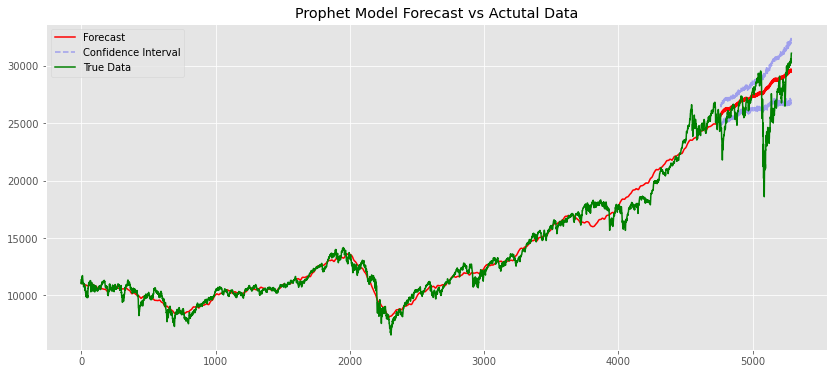

In [29]:
# the 1 sigma upper and lower analytic population bounds
lower_bound = (forecast.yhat_lower.iloc[train_size+1:])
upper_bound = (forecast.yhat_upper.iloc[train_size+1:])

# plot against true data
plt.plot(forecast['yhat'],c='r',label='Forecast')
plt.plot(lower_bound,
         linestyle='--',c='b',alpha=0.3,
         label='Confidence Interval')
plt.plot(upper_bound,
         linestyle='--',c='b',alpha=0.3)
plt.plot(prophet['y'],c='g',label='True Data')
plt.legend()
plt.title('Prophet Model Forecast vs Actutal Data')
plt.show()

In [30]:
pd.DataFrame(forecast.yhat.tail())

<IPython.core.display.Javascript object>

,yhat
5283,29466.557252
5284,29467.488063
5285,29718.486820
5286,29719.326242
5287,29469.752189


In [31]:
test.tail()

,ds,y
5284,2021-01-04,30223.890625
5285,2021-01-05,30391.599609
5286,2021-01-06,30829.400391
5287,2021-01-07,31041.130859
5288,2021-01-08,31097.970703


In [33]:
combine = pd.concat([test.tail(), pd.DataFrame(forecast.yhat.tail())], axis=1).dropna()
combine['accuracy'] = round(combine.apply(lambda row: row.yhat / 
                                            row.y *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']], 
                                     index = combine.index)
combine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ds,y,yhat,accuracy
5284,2021-01-04,30223.890625,29467.488063,97.50%
5285,2021-01-05,30391.599609,29718.486820,97.79%
5286,2021-01-06,30829.400391,29719.326242,96.40%
5287,2021-01-07,31041.130859,29469.752189,94.94%


In [36]:
window = 6
x_train,y_train,x_test,y_test,scaler = get_reg_train_test(dji_series,
                                                      sequence_length=window+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)
    
print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(4754, 6, 1)
y_train shape=(4754,)
x_test shape=(528, 6, 1)
y_test shape=(528,)


In [37]:
import itertools
import time

pred_length = int(window/2)
stock_index = '^DJI'

# prepare LSTM model
stm_model=None
try:
    lstm_model = get_reg_model(layer_units=[50,100],window_size=window)   
except:
    print("Model Build Failed. Trying Again")
    lstm_model = get_reg_model(layer_units=[50,100],window_size=window)

> Compilation Time :  0.015563488006591797
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 6, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________

In [38]:
# eatrly stopping to avoid overfitting     
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,verbose=0)]
lstm_model.fit(x_train, y_train, epochs=20, batch_size=16,verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Epoch 1/20
283/283 [==============================] - 6s 9ms/step - loss: 3.4952e-04 - val_loss: 1.8163e-04
Epoch 2/20
283/283 [==============================] - 2s 7ms/step - loss: 1.7136e-04 - val_loss: 1.2639e-04
Epoch 3/20
283/283 [==============================] - 2s 7ms/step - loss: 1.6264e-04 - val_loss: 1.2114e-04
Epoch 4/20
283/283 [==============================] - 2s 7ms/step - loss: 1.5533e-04 - val_loss: 1.0776e-04
Epoch 5/20
283/283 [==============================] - 2s 7ms/step - loss: 1.4803e-04 - val_loss: 1.1010e-04
Epoch 6/20
283/283 [==============================] - 2s 7ms/step - loss: 1.4453e-04 - val_loss: 1.1148e-04
Model Fit Complete


**Performance on train data**

In [39]:
train_pred = predict_reg_multiple(lstm_model,x_train, window_size=window,prediction_len=pred_length)
train_offset = y_train.shape[0] - np.array(train_pred).flatten().shape[0]

train_rmse = math.sqrt(mean_squared_error(y_train[train_offset:], np.array(train_pred).flatten()))
print('Train Score: %.2f RMSE' % (train_rmse))

# Test Prediction Performance
test_pred = \
predict_reg_multiple(lstm_model,x_test, window_size=window,prediction_len=pred_length)
test_offset = y_test.shape[0] - np.array(test_pred).flatten().shape[0]

test_rmse = \
math.sqrt(mean_squared_error(y_test[test_offset:], np.array(test_pred).flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

Train Score: 0.03 RMSE
Test Score: 0.03 RMSE


**Test Prediction Performance**

In [41]:
test_pred = \
predict_reg_multiple(lstm_model,x_test, window_size=window,prediction_len=pred_length)
test_offset = y_test.shape[0] - np.array(test_pred).flatten().shape[0]

test_rmse = \
math.sqrt(mean_squared_error(y_test[test_offset:], np.array(test_pred).flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

Test Score: 0.03 RMSE


**Plot Test Predictions**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

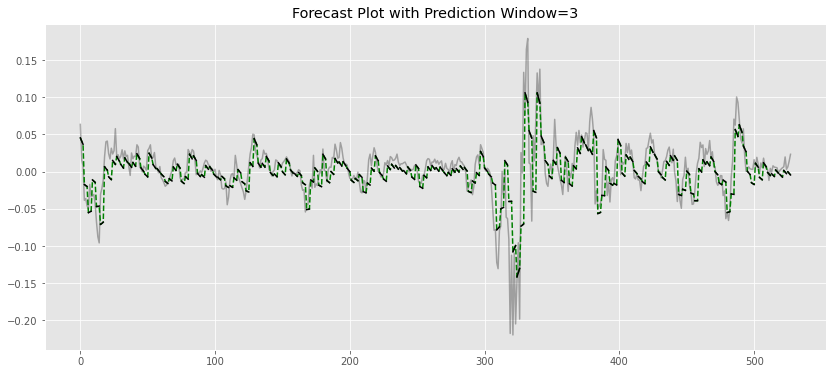

<IPython.core.display.Javascript object>

In [42]:
plot_reg_results(test_pred,y_test,prediction_len=pred_length)
plt.show()

In [43]:
train_percent = 0.7
verbose=True

# split train and test datasets
train,test,scaler = \
get_seq_train_test(dji_series,scaling=True,train_size=train_percent)

train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 3701, 1)
train_y shape=(1, 3701, 1)
test_x shape=(1, 1586, 1)
test_y shape=(1, 1586, 1)


In [44]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),verbose=verbose)   
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),verbose=verbose)

> Compilation Time :  0.008313417434692383
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3701, 4)           96        
_________________________________________________________________
time_distributed (TimeDistri (None, 3701, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# train the model
seq_lstm_model.fit(train_x, train_y, epochs=10, batch_size=1, verbose=2)
print("Model Fit Complete")

Epoch 1/10
1/1 - 2s - loss: 0.1154
Epoch 2/10
1/1 - 1s - loss: 0.1081
Epoch 3/10
1/1 - 1s - loss: 0.1032
Epoch 4/10
1/1 - 1s - loss: 0.0992
Epoch 5/10
1/1 - 1s - loss: 0.0959
Epoch 6/10
1/1 - 1s - loss: 0.0929
Epoch 7/10
1/1 - 1s - loss: 0.0902
Epoch 8/10
1/1 - 1s - loss: 0.0877
Epoch 9/10
1/1 - 1s - loss: 0.0853
Epoch 10/10
1/1 - 1s - loss: 0.0831
Model Fit Complete


In [46]:
# train fit performance
train_predict = seq_lstm_model.predict(train_x)
train_score = math.sqrt(mean_squared_error(train_y[0], train_predict[0]))
print('Train Score: %.2f RMSE' % (train_score))

Train Score: 0.28 RMSE


In [47]:
# inverse train transformation
train_predict = scaler.inverse_transform(train_predict.reshape(-1,1))
train_predict

array([[6557.622 ],
       [6246.3413],
       [5975.154 ],
       ...,
       [2650.5977],
       [2642.518 ],
       [2626.73  ]], dtype=float32)

In [48]:
from keras.preprocessing.sequence import pad_sequences

# Pad input sequence
# pad_sequences is used to ensure that all sequences in a list have the same length.
test_predict = pad_sequences(test_x,maxlen=train_x.shape[1], padding='post',
                             value=0,dtype='float')
test_predict

array([[[0.43279965],
        [0.42804176],
        [0.43432223],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [49]:
# forecast values
test_predict = seq_lstm_model.predict(test_predict)

In [ ]:
# evaluate performances
test_score = math.sqrt(mean_squared_error(test_y[0], 
                                          test_predict[0][test_x.shape[1]]))
print('Test Score: %.2f RMSE' % (test_score))

In [51]:
# inverse test transformation
test_predict = scaler.inverse_transform(test_predict.reshape(-1,1))
test_predict

array([[5897.2417],
       [5032.4224],
       [4346.1753],
       ...,
       [7573.3174],
       [7573.3174],
       [7573.3174]], dtype=float32)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

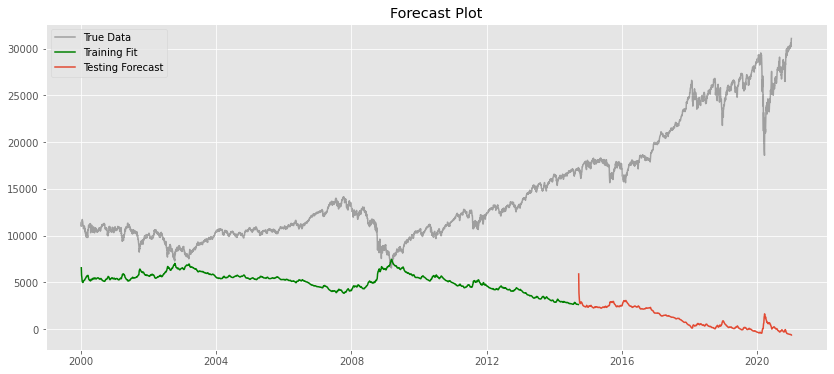

In [52]:
# plot the true and forecasted values
train_size = len(train_predict)+1

plt.plot(dji_series.index,
         dji_series.values,c='black',
         alpha=0.3,label='True Data')
plt.plot(dji_series.index[1:train_size],
         train_predict,label='Training Fit',c='g')
plt.plot(dji_series.index[train_size+1:],
         test_predict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
plt.show()
